In [ ]:
# default_exp modules.data_trackMultiCalo

In [ ]:
#export
import numpy as np
import pandas as pd
import glob
import os
import uproot as ur
import time
from multiprocessing import Process, Queue, set_start_method
import compress_pickle as pickle
from scipy.stats import circmean
import random
import itertools

# GraphDataGenerator

> API details.

In [ ]:
#hide
from nbdev.showdoc import *
np.set_printoptions(precision=3, suppress=True)

In [ ]:
np.set_printoptions(precision=5, suppress=True)

In [ ]:
#export
class MultiCaloTrackDataGenerator:
    """DataGenerator class for extracting and formating data from list of root files"""
    def __init__(self,
                 pion_file_list: list,
                 cellGeo_file: str,
                 batch_size: int,
                 n_clusters: int,
                 shuffle: bool = True,
                 num_procs: int = 32,
                 preprocess: bool = False,
                 output_dir: str = None):
        """Initialization"""

        self.preprocess = preprocess
        self.output_dir = output_dir
        
        if self.preprocess and self.output_dir is not None:
            self.pion_file_list = pion_file_list
            self.num_files = len(self.pion_file_list)
        else:
            self.file_list = pion_file_list
            self.num_files = len(self.file_list)
        
        self.cellGeo_file = cellGeo_file
        
        self.cellGeo_data = ur.open(self.cellGeo_file)['CellGeo']
        self.geoFeatureNames = self.cellGeo_data.keys()[1:9]
        self.nodeFeatureNames = ['cluster_cell_E', *self.geoFeatureNames[:-2], 'cluster_E']
        self.num_nodeFeatures = len(self.nodeFeatureNames)

        self.edgeFeatureNames = self.cellGeo_data.keys()[9:]
        self.num_edgeFeatures = len(self.edgeFeatureNames)

        self.cellGeo_data = self.cellGeo_data.arrays(library='np')
        self.cellGeo_ID = self.cellGeo_data['cell_geo_ID'][0]
        self.sorter = np.argsort(self.cellGeo_ID)
        
        self.track_feature_names = ['trackPt','trackD0','trackZ0', 'trackEta_EMB2','trackPhi_EMB2',
                                    'trackEta','trackPhi','truthPartE', 'truthPartPt', 'num_clusters']
        self.cluster_feature_names = ['cluster_E', 'cluster_Eta', 'cluster_Phi', 'cluster_ENG_CALIB_TOT', 
                                      'cluster_EM_PROBABILITY','cluster_E_LCCalib','cluster_HAD_WEIGHT', 'dR']
        
        self.dr_thresh = 1.2
        self.clusterThresh = .5
        
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.n_clusters = n_clusters
        
        if self.shuffle: np.random.shuffle(self.file_list)
        
        self.num_procs = num_procs
        self.procs = []

        if self.preprocess and self.output_dir is not None:
            os.makedirs(self.output_dir, exist_ok=True)
            self.preprocess_data()
    
    def get_cluster_inds(self, event_data, event_ind):
        
        if self.n_clusters==-1:   # get all nodes satisfying dR criterion
            c_inds = range(event_data['nCluster'][event_ind])
            c_inds = [c for c in c_inds if (event_data['dR'][event_ind][c]<self.dr_thresh) and 
                      (event_data['cluster_E'][event_ind][c]>self.clusterThresh)]
        else:                # get n leading nodes satisfying dR criterion
            c_inds = np.argsort(event_data['cluster_E'][event_ind])[::-1]
            c_inds = [c for c in c_inds if (event_data['dR'][event_ind][c]<self.dr_thresh) and 
                      (event_data['cluster_E'][event_ind][c]>self.clusterThresh)]
            c_inds = c_inds[:self.n_clusters]
        
        return c_inds
    
    def get_meta(self, event_data, event_ind, c_inds):
        """ 
        Reading meta data
        """  
        track_meta_data = []
        for f in self.track_feature_names[:-1]:
            track_meta_data.append(event_data[f][event_ind])
        track_meta_data.append(len(c_inds))
        
        cluster_meta_data = []
        for c in c_inds:
            curr_meta = []
            
            for f in self.cluster_feature_names:
                curr_meta.append(event_data[f][event_ind][c])
            
            cluster_meta_data.append(curr_meta)
            
        return np.array(track_meta_data, dtype=np.float32), np.array(cluster_meta_data, dtype=np.float32)
    
    def get_nodes(self, event_data, event_ind, cluster_ind):
        """ Reading Node features """ 

        cell_IDs = event_data['cluster_cell_ID'][event_ind][cluster_ind]
        cell_IDmap = self.sorter[np.searchsorted(self.cellGeo_ID, cell_IDs, sorter=self.sorter)]
        
        nodes = np.log10(event_data['cluster_cell_E'][event_ind][cluster_ind])
        
        # Scaling the cell_geo_sampling by 28
        nodes = np.append(nodes, self.cellGeo_data['cell_geo_sampling'][0][cell_IDmap]/28.)
        for f in self.nodeFeatureNames[2:4]:
            nodes = np.append(nodes, self.cellGeo_data[f][0][cell_IDmap])
        # Scaling the cell_geo_rPerp by 3000
        nodes = np.append(nodes, self.cellGeo_data['cell_geo_rPerp'][0][cell_IDmap]/3000.)
        for f in self.nodeFeatureNames[5:-1]:
            nodes = np.append(nodes, self.cellGeo_data[f][0][cell_IDmap])
        
        nodes = np.reshape(nodes, (len(self.nodeFeatureNames)-1, -1)).T
        cluster_E = np.log10(event_data['cluster_E'][event_ind][cluster_ind])
        cluster_E = np.repeat([[cluster_E]], len(nodes), axis=0)
        nodes = np.hstack([nodes, cluster_E])

        cluster_num_nodes = len(nodes)
        
        return nodes, cluster_num_nodes, cell_IDmap
                     
    def get_edges(self, cluster_num_nodes, cell_IDmap):
        """ 
        Reading edge features 
        Resturns senders, receivers, and edges    
        """ 
        
        edge_inds = np.zeros((cluster_num_nodes, self.num_edgeFeatures))
        for i, f in enumerate(self.edgeFeatureNames):
            edge_inds[:, i] = self.cellGeo_data[f][0][cell_IDmap]
        edge_inds[np.logical_not(np.isin(edge_inds, cell_IDmap))] = np.nan
        
        senders, edge_on_inds = np.isin(edge_inds, cell_IDmap).nonzero()
        cluster_num_edges = len(senders)
        edges = np.zeros((cluster_num_edges, self.num_edgeFeatures))
        edges[np.arange(cluster_num_edges), edge_on_inds] = 1
        
        cell_IDmap_sorter = np.argsort(cell_IDmap)
        rank = np.searchsorted(cell_IDmap, edge_inds , sorter=cell_IDmap_sorter)
        receivers = cell_IDmap_sorter[rank[rank!=cluster_num_nodes]]
        
        return senders, receivers, edges

    def preprocessor(self, worker_id):
        file_num = worker_id
        while file_num < self.num_files:
            print(f"Proceesing file {os.path.basename(self.pion_file_list[file_num])}")
            file = self.pion_file_list[file_num]
            event_data = np.load(file, allow_pickle=True).item()
            num_events = len(event_data[[key for key in event_data.keys()][0]])

            preprocessed_data = []

            for event_ind in range(num_events):
                truth_particle_E = np.log10(event_data['truthPartE'][event_ind][0]) # first one is the pion! 
                trackPt = event_data['trackPt'][event_ind][0]
                if trackPt>5000:
                    continue
                    
                trackEta = event_data['trackEta'][event_ind][0]
                global_node = np.array([np.log10(trackPt), trackEta], dtype=np.float32)
        
                c_inds = self.get_cluster_inds(event_data, event_ind)
                if not len(c_inds):
                    continue
                
                nodes = []
                senders = []
                receivers = []
                edges = []
                offset = 0
                for c in c_inds:
                    curr_nodes, cluster_num_nodes, cell_IDmap = self.get_nodes(event_data, event_ind, c)
                    curr_senders, curr_receivers, curr_edges = self.get_edges(cluster_num_nodes, cell_IDmap)
                    
                    nodes.append(curr_nodes)
                    edges.append(curr_edges)
                    senders.append(curr_senders + offset)
                    receivers.append(curr_receivers + offset)
                    
                    offset += len(curr_nodes)
                
                nodes = np.concatenate(nodes)
                edges = np.concatenate(edges)
                senders = np.concatenate(senders)
                receivers = np.concatenate(receivers)
                
                track_meta_data, cluster_meta_data = self.get_meta(event_data, event_ind, c_inds)
                
                graph = {'nodes': nodes.astype(np.float32), 
                         'globals': global_node.astype(np.float32),
                         'senders': senders.astype(np.int32), 
                         'receivers': receivers.astype(np.int32),
                         'edges': edges.astype(np.float32)}
                target = truth_particle_E.astype(np.float32)

                preprocessed_data.append((graph, target, track_meta_data, cluster_meta_data))

            random.shuffle(preprocessed_data)

            pickle.dump(preprocessed_data, open(self.output_dir + f'data_{file_num:03d}.p', 'wb'), compression='gzip')

            print(f"Finished processing {file_num} files")
            file_num += self.num_procs

    def preprocess_data(self):
        print('\nPreprocessing and saving data to {}'.format(self.output_dir))
        for i in range(self.num_procs):
            p = Process(target=self.preprocessor, args=(i,), daemon=True)
            p.start()
            self.procs.append(p)
        
        for p in self.procs:
            p.join()

        self.file_list = [self.output_dir + f'data_{i:03d}.p' for i in range(self.num_files)]

    def preprocessed_worker(self, worker_id, batch_queue):
        batch_graphs = []
        batch_targets = []
        batch_track_meta = []
        batch_cluster_meta = []
        
        file_num = worker_id
        while file_num < self.num_files:
            file_data = pickle.load(open(self.file_list[file_num], 'rb'), compression='gzip')

            for i in range(len(file_data)):
                batch_graphs.append(file_data[i][0])
                batch_targets.append(file_data[i][1])
                batch_track_meta.append(file_data[i][2])
                batch_cluster_meta.append(file_data[i][3])
                    
                if len(batch_graphs) == self.batch_size:
                    batch_targets = np.array(batch_targets).astype(np.float32)
                    batch_queue.put((batch_graphs, batch_targets, batch_track_meta, batch_cluster_meta))
                    
                    batch_graphs = []
                    batch_targets = []
                    batch_track_meta = []
                    batch_cluster_meta = []

            file_num += self.num_procs
                    
        if len(batch_graphs) > 0:
            batch_targets = np.array(batch_targets).astype(np.float32)
            batch_queue.put((batch_graphs, batch_targets, batch_track_meta, batch_cluster_meta))

    def worker(self, worker_id, batch_queue):
        if self.preprocess:
            self.preprocessed_worker(worker_id, batch_queue)
        else:
            raise Exception('Preprocessing is required for combined classification/regression models.')
        
    def check_procs(self):
        for p in self.procs:
            if p.is_alive(): return True
        
        return False

    def kill_procs(self):
        for p in self.procs:
            p.kill()

        self.procs = []
    
    def generator(self):
        # for file in self.file_list:
        batch_queue = Queue(2 * self.num_procs)
            
        for i in range(self.num_procs):
            p = Process(target=self.worker, args=(i, batch_queue), daemon=True)
            p.start()
            self.procs.append(p)
        
        while self.check_procs() or not batch_queue.empty():
            try:
                batch = batch_queue.get(True, 0.0001)
            except:
                continue
            
            yield batch
        
        for p in self.procs:
            p.join()

Test the data generation step...

In [ ]:
pion_dir = '/usr/workspace/hip/ML4Jets/regression_images/graphs.v01-45-gaa27bcb/onetrack_multicluster/pion_files/'
pion_files = np.sort(glob.glob(pion_dir+"*.npy"))
n_files = 3

cell_geo_file = '/usr/workspace/hip/ML4Jets/regression_images/graph_examples/cell_geo.root'

In [ ]:
data_gen = MultiCaloTrackDataGenerator(pion_file_list=pion_files[:n_files],
                                       cellGeo_file=cell_geo_file,
                                       batch_size=32,
                                       n_clusters=-1,
                                       shuffle=False,
                                       num_procs=32,
                                       preprocess=True,
                                       output_dir='./')


Preprocessing and saving data to ./
Proceesing file 001.npy
Proceesing file 002.npy
Proceesing file 003.npy
Finished processing 2 files
Finished processing 1 files
Finished processing 0 files


In [ ]:
graph, target, track_meta_data, cluster_meta_data = next(data_gen.generator())

In [ ]:
graph[ind]['nodes']

array([[ 0.471,  0.429, -0.85 , -2.209,  0.817,  0.1  ,  0.098,  0.69 ],
       [-0.404,  0.429, -0.85 , -2.307,  0.817,  0.1  ,  0.098,  0.69 ],
       [-0.436,  0.429, -0.85 , -2.111,  0.817,  0.1  ,  0.098,  0.69 ],
       [-0.44 ,  0.429, -0.95 , -2.307,  0.817,  0.1  ,  0.098,  0.69 ],
       [-1.6  ,  0.429, -0.75 , -2.307,  0.817,  0.1  ,  0.098,  0.69 ],
       [-0.908,  0.429, -0.95 , -2.111,  0.817,  0.1  ,  0.098,  0.69 ],
       [-1.046,  0.429, -0.75 , -2.111,  0.817,  0.1  ,  0.098,  0.69 ],
       [-2.133,  0.464, -0.85 , -2.209,  0.932,  0.1  ,  0.098,  0.69 ],
       [-1.457,  0.107, -0.873, -2.168,  0.645,  0.05 ,  0.025,  0.69 ],
       [-1.572,  0.429, -0.85 , -2.405,  0.817,  0.1  ,  0.098,  0.69 ],
       [-1.289,  0.464, -0.75 , -2.307,  1.007,  0.1  ,  0.098,  0.69 ],
       [-2.061,  0.464, -0.85 , -2.307,  0.932,  0.1  ,  0.098,  0.69 ],
       [-1.7  ,  0.107, -0.823, -2.34 ,  0.649,  0.05 ,  0.025,  0.69 ],
       [-1.508,  0.107, -0.823, -2.291,  0.649,  0.

In [ ]:
num_clusts = np.array(track_meta_data).squeeze()
num_clusts[:,-1]

array([2., 1., 3., 4., 3., 4., 2., 1., 1., 2., 4., 2., 4., 3., 4., 1., 2.,
       1., 3., 2., 2., 5., 1., 3., 4., 1., 3., 2., 4., 3., 1., 6.],
      dtype=float32)

In [ ]:
for i in range(32):
    num_diff_clustE = len(np.unique(graph[i]['nodes'][:, -1]))
    assert(num_diff_clustE==num_clusts[i, -1])

In [ ]:
from scipy import sparse
ind = 6
row = graph[ind]['senders']
col = graph[ind]['receivers']
values = np.ones(len(row))
num_nodes = graph[ind]['nodes'].shape[0]
out = sparse.coo_matrix((values, (row, col)), (num_nodes, num_nodes))
out.A

array([[0., 1., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
import matplotlib.pyplot as plt

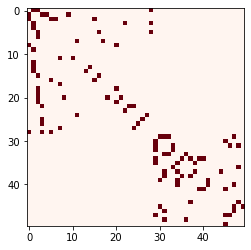

In [ ]:
plt.imshow(out.A, cmap='Reds')
plt.show()

In [ ]:
temp = graph[0]['nodes']
fake_E = 3.4
fake_E = np.repeat([[fake_E]], len(temp), axis=0)
temp = np.hstack([temp, fake_E])
temp.shape

(72, 8)

In [ ]:
fake_E.shape

(72, 1)

In [ ]:
#export
class MultiCaloTrackInferData:
    """DataGenerator class for extracting and formating data from list of root files"""
    def __init__(self,
                 pion_file: str,
                 cellGeo_file: str,
                 batch_size: int,
                 n_clusters: int,
                 shuffle: bool = True,
                 num_procs: int = 32,
                 preprocess: bool = False,
                 output_dir: str = None):
        """Initialization"""

        self.preprocess = preprocess
        self.output_dir = output_dir
        
        self.pion_file = pion_file
        self.num_files = 1
        
        self.cellGeo_file = cellGeo_file
        
        self.cellGeo_data = ur.open(self.cellGeo_file)['CellGeo']
        self.geoFeatureNames = self.cellGeo_data.keys()[1:9]
        self.nodeFeatureNames = ['cluster_cell_E', *self.geoFeatureNames[:-2], 'cluster_E']
        self.num_nodeFeatures = len(self.nodeFeatureNames)

        self.edgeFeatureNames = self.cellGeo_data.keys()[9:]
        self.num_edgeFeatures = len(self.edgeFeatureNames)

        self.cellGeo_data = self.cellGeo_data.arrays(library='np')
        self.cellGeo_ID = self.cellGeo_data['cell_geo_ID'][0]
        self.sorter = np.argsort(self.cellGeo_ID)
        
        self.track_feature_names = ['trackPt','trackD0','trackZ0', 'trackEta_EMB2','trackPhi_EMB2',
                                    'trackEta','trackPhi','truthPartE', 'truthPartPt', 'num_clusters']
        self.cluster_feature_names = ['cluster_E', 'cluster_Eta', 'cluster_Phi', 'cluster_ENG_CALIB_TOT', 
                                      'cluster_EM_PROBABILITY','cluster_E_LCCalib','cluster_HAD_WEIGHT', 'deltaR']
        
        self.dr_thresh = 1.2
        self.clusterThresh = .5
        
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.n_clusters = n_clusters
        
        if self.shuffle: np.random.shuffle(self.file_list)
        
        self.num_procs = num_procs
        self.procs = []

        if self.preprocess and self.output_dir is not None:
            os.makedirs(self.output_dir, exist_ok=True)
            self.preprocess_data()
    
    def get_cluster_inds(self, event_data, event_ind):
        
        if self.n_clusters==-1:   # get all nodes satisfying dR criterion
            c_inds = range(event_data['nCluster'][event_ind])
            c_inds = [c for c in c_inds if (event_data['deltaR'][event_ind][c]<self.dr_thresh) and 
                      (event_data['cluster_E'][event_ind][c]>self.clusterThresh)]
        else:                # get n leading nodes satisfying dR criterion
            c_inds = np.argsort(event_data['cluster_E'][event_ind])[::-1]
            c_inds = [c for c in c_inds if (event_data['deltaR'][event_ind][c]<self.dr_thresh) and 
                      (event_data['cluster_E'][event_ind][c]>self.clusterThresh)]
            c_inds = c_inds[:self.n_clusters]
        
        return c_inds
    
    def get_meta(self, event_data, event_ind, c_inds):
        """ 
        Reading meta data
        """  
        track_meta_data = []
        for f in self.track_feature_names[:-1]:
            track_meta_data.append(event_data[f][event_ind])
        track_meta_data.append(len(c_inds))
        
        cluster_meta_data = []
        for c in c_inds:
            curr_meta = []
            
            for f in self.cluster_feature_names:
                curr_meta.append(event_data[f][event_ind][c])
            
            cluster_meta_data.append(curr_meta)
            
        return np.array(track_meta_data, dtype=np.float32), np.array(cluster_meta_data, dtype=np.float32)
    
    def get_nodes(self, event_data, event_ind, cluster_ind):
        """ Reading Node features """ 

        cell_IDs = event_data['cluster_cell_ID'][event_ind][cluster_ind]
        cell_IDmap = self.sorter[np.searchsorted(self.cellGeo_ID, cell_IDs, sorter=self.sorter)]
        
        nodes = np.log10(event_data['cluster_cell_E'][event_ind][cluster_ind])
        
        # Scaling the cell_geo_sampling by 28
        nodes = np.append(nodes, self.cellGeo_data['cell_geo_sampling'][0][cell_IDmap]/28.)
        for f in self.nodeFeatureNames[2:4]:
            nodes = np.append(nodes, self.cellGeo_data[f][0][cell_IDmap])
        # Scaling the cell_geo_rPerp by 3000
        nodes = np.append(nodes, self.cellGeo_data['cell_geo_rPerp'][0][cell_IDmap]/3000.)
        for f in self.nodeFeatureNames[5:-1]:
            nodes = np.append(nodes, self.cellGeo_data[f][0][cell_IDmap])
        
        nodes = np.reshape(nodes, (len(self.nodeFeatureNames)-1, -1)).T
        cluster_E = np.log10(event_data['cluster_E'][event_ind][cluster_ind])
        cluster_E = np.repeat([[cluster_E]], len(nodes), axis=0)
        nodes = np.hstack([nodes, cluster_E])

        cluster_num_nodes = len(nodes)
        
        return nodes, cluster_num_nodes, cell_IDmap
                     
    def get_edges(self, cluster_num_nodes, cell_IDmap):
        """ 
        Reading edge features 
        Resturns senders, receivers, and edges    
        """ 
        
        edge_inds = np.zeros((cluster_num_nodes, self.num_edgeFeatures))
        for i, f in enumerate(self.edgeFeatureNames):
            edge_inds[:, i] = self.cellGeo_data[f][0][cell_IDmap]
        edge_inds[np.logical_not(np.isin(edge_inds, cell_IDmap))] = np.nan
        
        senders, edge_on_inds = np.isin(edge_inds, cell_IDmap).nonzero()
        cluster_num_edges = len(senders)
        edges = np.zeros((cluster_num_edges, self.num_edgeFeatures))
        edges[np.arange(cluster_num_edges), edge_on_inds] = 1
        
        cell_IDmap_sorter = np.argsort(cell_IDmap)
        rank = np.searchsorted(cell_IDmap, edge_inds , sorter=cell_IDmap_sorter)
        receivers = cell_IDmap_sorter[rank[rank!=cluster_num_nodes]]
        
        return senders, receivers, edges

    def preprocessor(self, worker_id):
        file_num = worker_id
        while file_num < self.num_files:
            print(f"Proceesing file {os.path.basename(self.pion_file)}")
            file = self.pion_file
            event_data = pd.read_pickle(file)
            num_events = len(event_data)

            preprocessed_data = []

            for event_ind in event_data.index:
                truth_particle_E = np.log10(event_data['truthPartE'][event_ind][0]) # first one is the pion! 
                trackPt = event_data['trackPt'][event_ind][0]
                if trackPt>5000:
                    continue
                    
                trackEta = event_data['trackEta'][event_ind][0]
                global_node = np.array([np.log10(trackPt), trackEta], dtype=np.float32)
        
                c_inds = self.get_cluster_inds(event_data, event_ind)
                if not len(c_inds):
                    continue
                
                nodes = []
                senders = []
                receivers = []
                edges = []
                offset = 0
                for c in c_inds:
                    curr_nodes, cluster_num_nodes, cell_IDmap = self.get_nodes(event_data, event_ind, c)
                    curr_senders, curr_receivers, curr_edges = self.get_edges(cluster_num_nodes, cell_IDmap)
                    
                    nodes.append(curr_nodes)
                    edges.append(curr_edges)
                    senders.append(curr_senders + offset)
                    receivers.append(curr_receivers + offset)
                    
                    offset += len(curr_nodes)
                
                nodes = np.concatenate(nodes)
                edges = np.concatenate(edges)
                senders = np.concatenate(senders)
                receivers = np.concatenate(receivers)
                
                track_meta_data, cluster_meta_data = self.get_meta(event_data, event_ind, c_inds)
                
                graph = {'nodes': nodes.astype(np.float32), 
                         'globals': global_node.astype(np.float32),
                         'senders': senders.astype(np.int32), 
                         'receivers': receivers.astype(np.int32),
                         'edges': edges.astype(np.float32)}
                target = truth_particle_E.astype(np.float32)

                preprocessed_data.append((graph, target, track_meta_data, cluster_meta_data))

            random.shuffle(preprocessed_data)

            pickle.dump(preprocessed_data, open(self.output_dir + f'data_{file_num:03d}.p', 'wb'), compression='gzip')

            print(f"Finished processing {file_num} files")
            file_num += self.num_procs

    def preprocess_data(self):
        print('\nPreprocessing and saving data to {}'.format(self.output_dir))
        for i in range(self.num_procs):
            p = Process(target=self.preprocessor, args=(i,), daemon=True)
            p.start()
            self.procs.append(p)
        
        for p in self.procs:
            p.join()

        self.file_list = [self.output_dir + f'data_{i:03d}.p' for i in range(self.num_files)]

    def preprocessed_worker(self, worker_id, batch_queue):
        batch_graphs = []
        batch_targets = []
        batch_track_meta = []
        batch_cluster_meta = []
        
        file_num = worker_id
        while file_num < self.num_files:
            file_data = pickle.load(open(self.file_list[file_num], 'rb'), compression='gzip')

            for i in range(len(file_data)):
                batch_graphs.append(file_data[i][0])
                batch_targets.append(file_data[i][1])
                batch_track_meta.append(file_data[i][2])
                batch_cluster_meta.append(file_data[i][3])
                    
                if len(batch_graphs) == self.batch_size:
                    batch_targets = np.array(batch_targets).astype(np.float32)
                    batch_queue.put((batch_graphs, batch_targets, batch_track_meta, batch_cluster_meta))
                    
                    batch_graphs = []
                    batch_targets = []
                    batch_track_meta = []
                    batch_cluster_meta = []

            file_num += self.num_procs
                    
        if len(batch_graphs) > 0:
            batch_targets = np.array(batch_targets).astype(np.float32)
            batch_queue.put((batch_graphs, batch_targets, batch_track_meta, batch_cluster_meta))

    def worker(self, worker_id, batch_queue):
        if self.preprocess:
            self.preprocessed_worker(worker_id, batch_queue)
        else:
            raise Exception('Preprocessing is required for combined classification/regression models.')
        
    def check_procs(self):
        for p in self.procs:
            if p.is_alive(): return True
        
        return False

    def kill_procs(self):
        for p in self.procs:
            p.kill()

        self.procs = []
    
    def generator(self):
        # for file in self.file_list:
        batch_queue = Queue(2 * self.num_procs)
            
        for i in range(self.num_procs):
            p = Process(target=self.worker, args=(i, batch_queue), daemon=True)
            p.start()
            self.procs.append(p)
        
        while self.check_procs() or not batch_queue.empty():
            try:
                batch = batch_queue.get(True, 0.0001)
            except:
                continue
            
            yield batch
        
        for p in self.procs:
            p.join()

In [ ]:
pion_file = '../df_transformer_debug.pkl'
cell_geo_file = '/usr/workspace/hip/ML4Jets/regression_images/graph_examples/cell_geo.root'

data_gen = MultiCaloTrackInferData(pion_file=pion_file,
                                   cellGeo_file=cell_geo_file,
                                   batch_size=32,
                                   n_clusters=-1,
                                   shuffle=False,
                                   num_procs=32,
                                   preprocess=True,
                                   output_dir='./')


Preprocessing and saving data to ./
Proceesing file df_transformer_debug.pkl
Finished processing 0 files


In [ ]:
graph, target, track_meta_data, cluster_meta_data = next(data_gen.generator())

In [ ]:
track_meta_data[0]

array([ 0.59222865,  6.6680737 , 27.934269  , -0.6480477 ,  0.8865697 ,
       -0.628881  , -0.4802343 ,  9.119415  ,  1.8925352 ,  1.        ],
      dtype=float32)

In [ ]:
data_gen.track_feature_names

['trackPt',
 'trackD0',
 'trackZ0',
 'trackEta_EMB2',
 'trackPhi_EMB2',
 'trackEta',
 'trackPhi',
 'truthPartE',
 'truthPartPt',
 'num_clusters']

In [ ]:
data = np.load('../df_transformer_debug.npz', allow_pickle=True)
event_data = data['data']
cols = data['columns']
index = data['index']
# num_events = len(event_data)

In [ ]:
tmp = pd.DataFrame(data=event_data, columns=cols, index=index)

In [ ]:
tmp.to_pickle('../df_transformer_debug.pkl')

In [ ]:
tmp = pd.read_pickle('../df_transformer_debug.pkl')

In [ ]:
tmp.columns

Index(['index', 'runNumber', 'eventNumber', 'lumiBlock', 'coreFlags',
       'mcEventNumber', 'mcChannelNumber', 'mcEventWeight', 'nTruthPart',
       'G4PreCalo_n_EM',
       ...
       'cluster_CENTER_LAMBDA', 'cluster_ISOLATION',
       'cluster_ENERGY_DigiHSTruth', 'cluster_cell_ID', 'cluster_cell_E',
       'cluster_hitsTruthIndex', 'cluster_hitsTruthE', 'deltaR', 'dR_pass',
       'event_number'],
      dtype='object', length=129)

In [ ]:
tmp[['trackPt','trackD0','trackZ0', 'trackEta_EMB2','trackPhi_EMB2',
     'trackEta','trackPhi','truthPartE', 'truthPartPt', 'cluster_E', 
     'cluster_Eta', 'cluster_Phi', 'deltaR']]

,trackPt,trackD0,trackZ0,trackEta_EMB2,trackPhi_EMB2,trackEta,trackPhi,truthPartE,truthPartPt,cluster_E,cluster_Eta,cluster_Phi,deltaR
4109,[0.56499124],[-7.4432144],[87.2737],[-0.292916],[-0.09242209],[-0.2805243],[-1.5919197],[1.638227],[0.6287291],[0.5934837],[-0.25973687],[-0.74060816],[0.8515652624760468]
9082,[0.59222865],[6.6680737],[27.934269],[-0.6480477],[0.8865697],[-0.628881],[-0.4802343],[9.119415],[1.8925352],[0.82536364],[-0.6838584],[0.3976988],[0.8796527826676044]
3985,[0.7130422],[-3.952645],[22.175701],[-1000000000.0],[-1000000000.0],[-1.9086738],[2.9050717],[29.691723],[8.562422],[0.66128916],[-1.5136156],[3.1018682],[0.4413612757326127]
8254,[436.06116],[0.0017354734],[25.76988],[0.01986047],[-1.1808629],[0.019860815],[-1.1825681],[499.59772],[499.4997],"[131.32864, 42.44467, 5.466173, 3.823332, 2.44...","[0.02523974, 0.032032937, 0.013351178, 0.01600...","[-1.1544378, -1.1846708, -1.2848923, -0.943424...","[0.028639940728819663, 0.012352409796186377, 0..."
3592,[1.1556271],[9.772532],[-44.83223],[-1000000000.0],[-1000000000.0],[-2.182635],[0.7438593],[100.29169],[10.957157],[1.7634326],[-1.6830969],[-0.09693346],[0.9779932768951003]
8425,[1118.2161],[-0.004356428],[-1.2269732],[-0.9787819],[-0.9380014],[-0.97878176],[-0.9386091],[995.07166],[655.1402],"[119.363686, 7.9105496, 5.7105308, 3.256291]","[-1.0072887, -1.0556288, -1.0082572, -1.1504852]","[-0.9378377, -0.9186243, -0.77520394, -1.1300832]","[0.028517369896244267, 0.07940313518030324, 0...."


In [ ]:
tmp[['eventNumber', 'truthPartEta', 'truthPartPhi', 'trackEta', 'trackPhi', 'cluster_Eta', 'cluster_Phi']]

,eventNumber,truthPartEta,truthPartPhi,trackEta,trackPhi,cluster_Eta,cluster_Phi
4109,8805468,[1.607805],[-1.7966828],[-0.2805243],[-1.5919197],[-0.25973687],[-0.74060816]
9082,1744200,[-2.25457],[-0.19429713],[-0.628881],[-0.4802343],[-0.6838584],[0.3976988]
3985,6740038,[-1.9151504],[2.8025804],[-1.9086738],[2.9050717],[-1.5136156],[3.1018682]
8254,9453782,[0.019807491],[-1.1825013],[0.019860815],[-1.1825681],"[0.02523974, 0.032032937, 0.013351178, 0.01600...","[-1.1544378, -1.1846708, -1.2848923, -0.943424..."
3592,6070536,[-2.9042387],[1.1400995],[-2.182635],[0.7438593],[-1.6830969],[-0.09693346]
8425,2149922,[-0.9791123],[-0.9387261],[-0.97878176],[-0.9386091],"[-1.0072887, -1.0556288, -1.0082572, -1.1504852]","[-0.9378377, -0.9186243, -0.77520394, -1.1300832]"


In [ ]:
tmp['cluste']

4109                                         [0.66069525]
9082                                          [1.7295669]
3985                                          [1.7862197]
8254    [164.663, 47.580204, 11.02904, 6.647328, 4.434...
3592                                          [5.3970976]
8425          [144.80768, 10.055521, 8.0233965, 4.009662]
Name: cluster_E_LCCalib, dtype: object

In [ ]:
res = np.load('../results/onetrack_multicluster/Block_20220613_2046_trackMultiCalo_regress/inference_predictions_debug_GNN.npz')
ind = np.argsort(res['targets'])
pd.DataFrame(list(zip(res['targets'][ind], res['outputs'].squeeze()[ind])), columns=['Target', 'GNN'])

,Target,GNN
0,1.638227,0.609559
1,9.119415,0.731308
2,29.691723,2.518506
3,100.291718,5.359109
4,499.597565,405.521271
5,995.071350,1319.857422


In [ ]:
res_deep = np.load('../results/onetrack_multicluster/Block_20220711_1016_trackMultiCalo_regress_deepset/inference_predictions_debug_Deepsets.npz')
ind_deep = np.argsort(res_deep['targets'])
list(zip(res_deep['targets'][ind_deep], res_deep['outputs'].squeeze()[ind_deep]))

[(1.638227, 0.59623784),
 (9.119415, 0.726395),
 (29.691723, 2.5295691),
 (100.29172, 5.16362),
 (499.59756, 437.69775),
 (995.07135, 1242.4777)]

In [ ]:
stacked_res = np.vstack([res['targets'][ind], res['outputs'].squeeze()[ind], res_deep['outputs'].squeeze()[ind_deep]])

In [ ]:
pd.DataFrame(data=stacked_res.T, columns=['Target', 'GNN', 'Deepsets'])

,Target,GNN,Deepsets
0,1.638227,0.609559,0.596238
1,9.119415,0.731308,0.726395
2,29.691723,2.518506,2.529569
3,100.291718,5.359109,5.163620
4,499.597565,405.521271,437.697754
5,995.071350,1319.857422,1242.477661


In [ ]:
track_meta_data

[array([ 0.59223,  6.66807, 27.93427, -0.64805,  0.88657, -0.62888,
        -0.48023,  9.11942,  1.89254,  1.     ], dtype=float32),
 array([ 0.56499, -7.44321, 87.2737 , -0.29292, -0.09242, -0.28052,
        -1.59192,  1.63823,  0.62873,  1.     ], dtype=float32),
 array([1118.2161 ,   -0.00436,   -1.22697,   -0.97878,   -0.938  ,
          -0.97878,   -0.93861,  995.07166,  655.1402 ,    4.     ],
       dtype=float32),
 array([436.06116,   0.00174,  25.76988,   0.01986,  -1.18086,   0.01986,
         -1.18257, 499.59772, 499.4997 ,   5.     ], dtype=float32),
 array([ 7.13042e-01, -3.95265e+00,  2.21757e+01, -1.00000e+09,
        -1.00000e+09, -1.90867e+00,  2.90507e+00,  2.96917e+01,
         8.56242e+00,  1.00000e+00], dtype=float32),
 array([ 1.15563e+00,  9.77253e+00, -4.48322e+01, -1.00000e+09,
        -1.00000e+09, -2.18264e+00,  7.43859e-01,  1.00292e+02,
         1.09572e+01,  1.00000e+00], dtype=float32)]